# TP1 - Détéctions de points d'intêrets

In [284]:

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import scipy.ndimage as ndi
import scipy.signal as sig
from skimage.io import imread,imshow
from skimage.color import rgb2gray
import cv2


'''
from scipy import signal as sig,ndimage
import numpy as np
from skimage.io import imread,imshow
from skimage.color import rgb2gray 
'''

'\nfrom scipy import signal as sig,ndimage\nimport numpy as np\nfrom skimage.io import imread,imshow\nfrom skimage.color import rgb2gray \n'

## Exercice 1 - Détection de points d'intérêts

### 1 - Détecteur de Harris


### Avec une fenêtre de pondération rectangulaire

In [288]:
def detection_harris(img_path,rot):
    

    img = imread(img_path)
    
    if rot != 0 :
        img= np.rot90(img,rot/90)
    img_gray=rgb2gray(img)


    width = np.shape(img_gray)[1] # largeur et hauteurs de l'image
    height = np.shape(img_gray)[0]

    Sobel_x = np.array([[1, 0, -1],[2, 0, -2],[1, 0, -1]]) # filtre de sobel pour la dérivée en x 
    Sobel_y = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]]) # filtre de sobel pour la dérivée en y

    Ix = sig.convolve2d(img_gray, Sobel_x, mode='same') # convolution par le filtre de Sobel
    Iy = sig.convolve2d(img_gray, Sobel_y, mode='same')


    Ix2= np.square(Ix) # les trois calculs pour la matrice M
    Iy2=np.square(Iy)
    IxIy= (Ix*Iy)

    img_copy_for_corners = np.copy(img) # on crée une copie pour ne pas altérer l'imgae d'originie
    k=0.02 # paramètre à ajuster
    count = 0
    for x in range(height): 
        for y in range(width):
            Mx = np.sum(Ix2[x-1:x+1, y-1:y+1]) # on calcule les sommes sur notre fenêtre 
            My = np.sum(Iy2[x-1:x+1, y-1:y+1])
            Mxy = np.sum(IxIy[x-1:x+1, y-1:y+1])
            deter = (Mx * My) - (Mxy**2) 
            trace = Mx + My
            C = deter - k*(trace**2) # calcul du critère pour le seuillage des points d'intérêts
            if C >0.1 :
                img_copy_for_corners[x, y] = [255,0,0] # on met en rouge les points d'intérêts
                count+=1
    return img_copy_for_corners,count

                

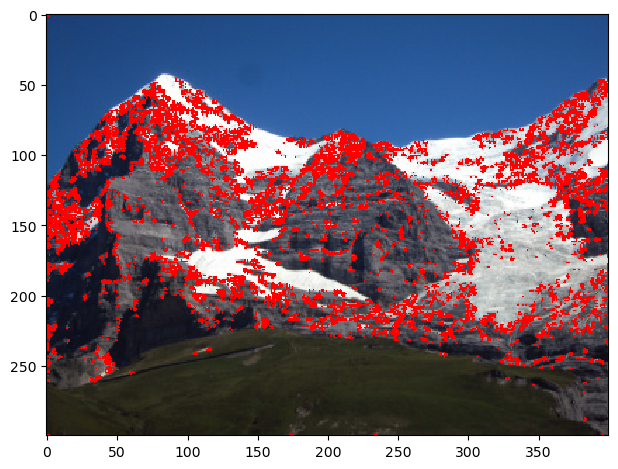

In [316]:
img= "M1.JPG"
coins_brute,count_rect = detection_harris(img,0)
imshow(coins_brute)

### Fonction pour la suppression des non-maxima locaux

In [317]:
def sup_non_maxima(img: np.ndarray,img_originale_path) -> np.ndarray:
    
    img_originale = imread(img_originale_path)
    
    image_avec_pt=np.copy(img)

    width = np.shape(img_gray)[1] # largeur et hauteurs de l'image
    height = np.shape(img_gray)[0]
    count_suppr = 0

    for x in range(height-1): 
        for y in range(width-1):
            intvect = [img_gray[x][y],img_gray[x-1][y],img_gray[x+1][y],img_gray[x-1][y-1],img_gray[x+1][y-1],img_gray[x][y-1],img_gray[x][y+1],img_gray[x-1][y+1],img_gray[x+1][y+1]]
            if 0.8*np.max(intvect) > img_gray[x][y] :        # si le pixel que l'on examine n'est pas un max local, 
                image_avec_pt[x][y] = img_originale[x][y]         # On lui rend sa couleur initiale (il ne sera plus en rouge)
    
    for x in range(height): 
        for y in range(width):
            if (image_avec_pt[x][y])[0] == 255 : 
                count_suppr +=1
    return image_avec_pt,count_suppr

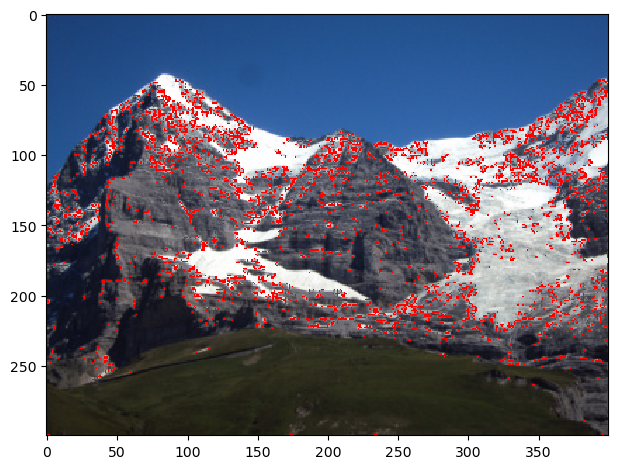

In [318]:
img_suppr,c_supr_rect= sup_non_maxima(coins_brute,img)
imshow(img_suppr)

### Avec une fenêtre de pondération gaussienne

In [319]:
def detection_harris_gauss(img_path,rot):

    img = imread(img_path)
    if rot != 0 :
        img= np.rot90(img,rot/90)
    img_gray=rgb2gray(img)


    width = np.shape(img_gray)[1] # largeur et hauteurs de l'image
    height = np.shape(img_gray)[0]
    Sobel_x = np.array([[1, 0, -1],[2, 0, -2],[1, 0, -1]]) # filtre de sobel pour la dérivée en x 
    Sobel_y = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]]) # filtre de sobel pour la dérivée en y


    Ix = sig.convolve2d(img_gray, Sobel_x, mode='same') # convolution par le filtre de Sobel
    Iy = sig.convolve2d(img_gray, Sobel_y, mode='same')


    Ix2= np.square(Ix) # les trois calculs pour la matrice M
    Iy2=np.square(Iy)
    IxIy= (Ix*Iy)
    
    
    sigma = 1
    kernel_size = 3  # Adjust the kernel size as needed
    gaussian_kernel = np.zeros((kernel_size, kernel_size))
    for y in range(kernel_size):
        for x in range(kernel_size):
            gaussian_kernel[y, x] = 1 / (2 * np.pi * sigma ** 2) * np.exp(-((x - (kernel_size - 1) / 2) ** 2 + (y - (kernel_size - 1) / 2) ** 2) / (2 * sigma ** 2))

    # Convolve the matrices with the Gaussian kernel
    Ix2gauss = sig.convolve2d(Ix2, gaussian_kernel, boundary='fill', mode='same')
    Iy2gauss = sig.convolve2d(Iy2, gaussian_kernel, boundary='fill', mode='same')
    IxIygauss = sig.convolve2d(IxIy, gaussian_kernel, boundary='fill', mode='same')

    img_copy_for_corners = np.copy(img) # on créer une copie pour ne pas altérer l'imgae d'originie
    k=0.04 # paramètre à ajuster
    count= 0
    
    for x in range(height):
        for y in range(width):
            deter = (Ix2gauss[x][y] * Iy2gauss[x][y]) - (IxIygauss[x][y]**2) 
            trace = Ix2gauss[x,y] + Iy2gauss[x,y]
            C = deter - k*(trace**2) # calcul du critère pour le seuillage des points d'intérêts
            if C >0.1 :
                img_copy_for_corners[x, y] = [255,0,0] # on met en rouge les points d'intérêts
                count += 1
    return img_copy_for_corners,count

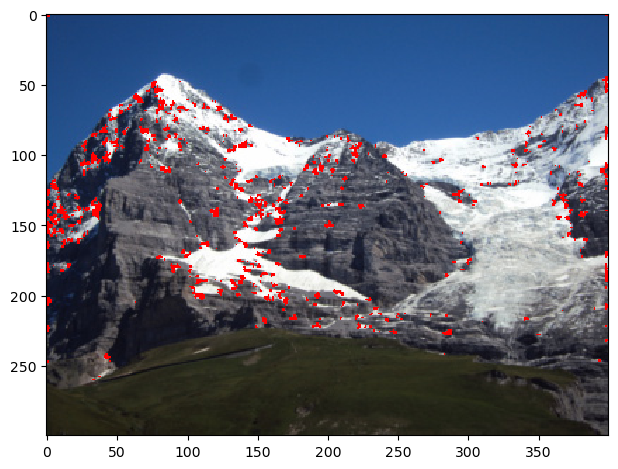

In [320]:
coins_brute_gauss,count_gauss= detection_harris_gauss(img,0)
imshow(coins_brute_gauss)

### Avec suppression :

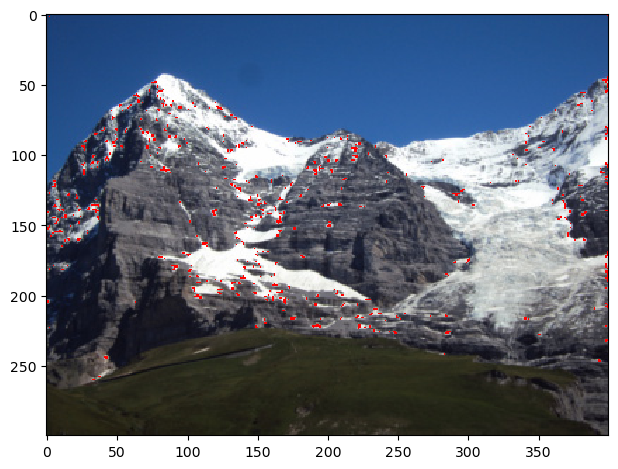

In [294]:
img_suppr_gauss,c_supr_gauss = sup_non_maxima(coins_brute_gauss,img)
imshow(img_suppr_gauss)

### Influence du type de fenêtre de pondération, de sa taille ainsi que du paramètre k dans la détection de point d’intérêt.

#### 1) Influence du type de fênetre 

In [282]:
print("le nombre de coins détéctés par la fenêtre rectangulaire est : " + str(count_rect) +"\n" + "le nombre de coins détécté par la fenêtre gaussienne est : " + str(count_gauss))
print("le nombres de points supprimés pour la fenêtre rectangulaire est : " + str(c_supr_rect) + "\n" + "le nombres de points supprimés pour la fenêtre gaussienne est : " + str(c_supr_gauss))

le nombre de coins détéctés par la fenêtre rectangulaire est : 16164
le nombre de coins détécté par la fenêtre gaussienne est : 3054
le nombres de points supprimés pour la fenêtre rectangulaire est : 7170
le nombres de points supprimés pour la fenêtre gaussienne est : 1502


In [283]:
#### 2) Influence de la taille de la fenêtre

### Rotation de l'image

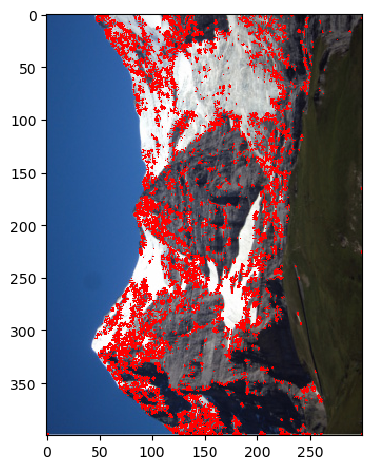

In [295]:
coins_brute_rota,count_rect_rota = detection_harris(img,90)
imshow(coins_brute_rota)


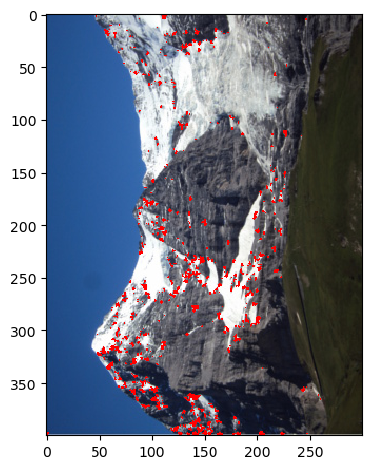

In [297]:
coins_brute_gauss_rota,count_gauss_rota = detection_harris_gauss(img,90)
imshow(coins_brute_gauss_rota)


In [298]:
print("le nombre de coins détéctés par la fenêtre rectangulaire est : " + str(count_rect_rota) +"\n" + "le nombre de coins détécté par la fenêtre gaussienne est : " + str(count_gauss_rota))
print("le nombres de points supprimés pour la fenêtre rectangulaire est : " + str(c_supr_rect) + "\n" + "le nombres de points supprimés pour la fenêtre gaussienne est : " + str(c_supr_gauss))

le nombre de coins détéctés par la fenêtre rectangulaire est : 16164
le nombre de coins détécté par la fenêtre gaussienne est : 3054
le nombres de points supprimés pour la fenêtre rectangulaire est : 7170
le nombres de points supprimés pour la fenêtre gaussienne est : 1502


### 2 - Détecteur FAST

On commence par implémenter une fonction qui récupère la valeur de l'intensité des 16 pixels du cercle autour du pixel $p_0$ que l'on cherche à tester.

In [303]:
''' Cette fonction permet de calculer les points d'un cercle de rayon 3
autour d'un point de coordonnées (ligne,col) et de renvoyer les coordonnées
de ces points dans une liste'''

def cercle(ligne: int, col: int) -> np.ndarray :
    

    pt = [(ligne-3, col),(ligne-3, col+1),(ligne-2, col+2),(ligne-1, col+3),(ligne, col+3),(ligne+1, col+3),
          (ligne+2, col+2),(ligne+3, col+1),(ligne+3, col),(ligne+3, col-1),(ligne+2, col-2),(ligne+1, col-3),
          (ligne, col-3),(ligne-1, col-3),(ligne-2, col-2),(ligne-3, col-1)]
    return pt

print(cercle(33,33))


[(30, 33), (30, 34), (31, 35), (32, 36), (33, 36), (34, 36), (35, 35), (36, 34), (36, 33), (36, 32), (35, 31), (34, 30), (33, 30), (32, 30), (31, 31), (30, 32)]


Puis, on implémente la fonction capable de comparer l'intensité des différents points du cercle autour de p0. Si n pixels du cercle ont une intensité suffisamment différente de celle de p0, la fonction renvoie True.

In [305]:
''' Cette fonction permet de comparer l'intensité du point p0 avec les points du cercle'''

def compare_Intensity(image: np.ndarray, pt_cercle: list, I_p0: float, t: float, n: int):
    sup_nb = 0
    for i in range(len(pt_cercle)):
        if (image[pt_cercle[i][0]][pt_cercle[i][1]] > t + I_p0) | (image[pt_cercle[i][0]][pt_cercle[i][1]] < I_p0 - t):
            sup_nb += 1     # on compte le nombre de points du cercle dont l'intensité est supérieure à celle du point p0
    if sup_nb >= n:       # si ce nombre est supérieur au paramètre n (à initialiser), on renvoie True, il s'agit d'un point d'intérêt
        return True
    else:
        return False     # sinon, on renvoie False, ce n'est pas un point d'intérêt
    

Enfin, on implémente la fonction $fast()$ qui utilise les deux fonctions précédentes pour chaque pixel de l'image (sauf ceux qui ce trouve aux extrémités de l'image et pour lesquels on ne peut pas tracer un cercle complet). Si $compare\_ Intensity()$ renvoie True, la fonction $fast()$ marque le point d'intérêt en rouge.

In [321]:

def fast(image_path: np.ndarray, t: float, n: int) -> np.ndarray:
    
    img = imread(image_path)


    width = np.shape(image)[1] # largeur et hauteurs de l'image
    height = np.shape(image)[0]
    x, y = 0, 0

    img_gray=rgb2gray(image)
    
    img_copy_for_FAST = np.copy(image)

    for x in range(3,height-3): 
        for y in range(3,width-3):
            
            pt_cercle = cercle(x,y)
            I_p0 = img_gray[x][y]

            if compare_Intensity(img_gray, pt_cercle, I_p0, t, n):
                img_copy_for_FAST[x][y] = [255,0,0]
            
            if((y+3)%width == 0):
                break
            
    
    return img_copy_for_FAST

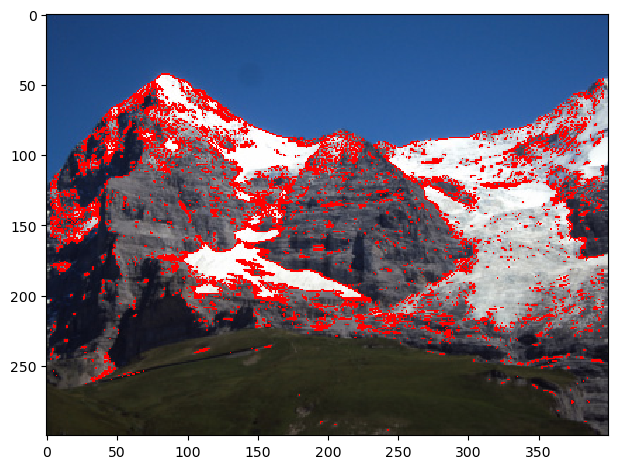

In [322]:
''' TEST de la méthode FAST '''

img_FAST = fast(img, 0.09, 12)

imshow(img_FAST)

### Suppression des non-maxima locaux pour FAST

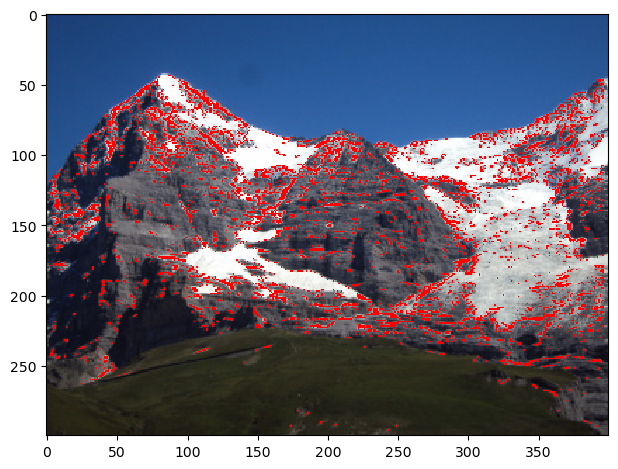

In [326]:

img_FAST = fast(img, 0.09, 10)
new_FAST_image,c = sup_non_maxima(img_FAST, img)

imshow(new_FAST_image)

### Affichage de la différence avec/sans maxima locaux

img_diff = img_FAST - new_FAST_image

#imshow(img_diff)

In [327]:
# Algo pour avoir les points d'intérêt en blanc sur fond de l'image en noire


def fast_comp(image: np.ndarray, t: float, n: int) -> np.ndarray:

    width = np.shape(image)[1] # largeur et hauteurs de l'image
    height = np.shape(image)[0]
    x, y = 0, 0

    img_gray=rgb2gray(image)
    
    img_copy_for_FAST = np.copy(img_gray)

    for x in range(3,height-3): 
        for y in range(3,width-3):
            
            pt_cercle = cercle(x,y)
            I_p0 = img_gray[x][y]

            if compare_Intensity(img_gray, pt_cercle, I_p0, t, n):
                img_copy_for_FAST[x][y] = [255,255,255]
            else :
                img_copy_for_FAST[x][y] = [0,0,0]
            
            if((y+3)%width == 0):
                img_copy_for_FAST[x][y] = [0,0,0]
                img_copy_for_FAST[x][y+1] = [0,0,0]
                img_copy_for_FAST[x][y+2] = [0,0,0]
                img_copy_for_FAST[x][y+3] = [0,0,0]
                break
            
    
    return img_copy_for_FAST

img = imread('M1.JPG')

img_FAST_black = fast_comp(img, 0.09, 10)

imshow(img_FAST_black)


ValueError: setting an array element with a sequence.